In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import pandas as pd
import numpy as np
import torch
import collections, re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
!pip3 install nltk
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.layers import  CuDNNLSTM 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df1=pd.read_csv("/content/drive/My Drive/NLP project/clean_data.csv",encoding='latin-1') #you need to change the path
df2=pd.read_csv("/content/drive/My Drive/NLP project/clean_data2.csv",encoding='latin-1') #you need to change the path
clean_data=df1.copy() #

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

train_indices, test_indices, y_train, y_test = train_test_split(np.arange(len(clean_data)), clean_data['fraudulent'],
                                                    stratify=clean_data['fraudulent'], 
                                                    test_size=0.3,random_state=0)
reduced_train_indices, val_indices, y_reduced_train, y_valid = train_test_split(train_indices, clean_data.loc[train_indices]['fraudulent'],
                                                    stratify=clean_data.loc[train_indices]['fraudulent'], 
                                                    test_size=0.2,random_state=0)

In [0]:
from keras.layers import concatenate
from keras import Sequential, Model
from sklearn.metrics import classification_report, confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
non_text= clean_data.drop(['title', 'job_id', 'company_profile','description','fraudulent'], axis=1).to_numpy()

In [7]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(np.array(reduced_train_indices).reshape(-1, 1), clean_data.iloc[reduced_train_indices]['fraudulent'])
X_resampled=X_resampled.flatten()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
train_df=clean_data["description"][X_resampled].tolist()
test_df=clean_data["description"][test_indices].tolist()
val_df=clean_data["description"][val_indices].tolist()

train_label=clean_data["fraudulent"][X_resampled].tolist()
test_label=clean_data["fraudulent"][test_indices].tolist()
val_label=clean_data["fraudulent"][val_indices].tolist()

train_df_com=clean_data["company_profile"][X_resampled].tolist()
test_df_com=clean_data["company_profile"][test_indices].tolist()
val_df_com=clean_data["company_profile"][val_indices].tolist()

Y1 = pd.get_dummies(clean_data['fraudulent']).values
Y1_train=Y1[X_resampled]
Y1_test=Y1[test_indices]
Y1_val=Y1[val_indices]

In [0]:
non_text_train=non_text[X_resampled]
non_text_val=non_text[val_indices]
non_text_test=non_text[test_indices]

In [0]:
train_text = train_df
train_text = [' '.join(t.split()[0:200]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
test_text = test_df
test_text = [' '.join(t.split()[0:200]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
val_text = val_df
val_text = [' '.join(t.split()[0:200]) for t in val_text]
val_text = np.array(val_text, dtype=object)[:, np.newaxis]

In [0]:
train_text_com = train_df_com
train_text_com = [' '.join(t.split()[0:200]) for t in train_text_com]
train_text_com = np.array(train_text_com, dtype=object)[:, np.newaxis]
test_text_com = test_df_com
test_text_com = [' '.join(t.split()[0:200]) for t in test_text_com]
test_text_com = np.array(test_text_com, dtype=object)[:, np.newaxis]
val_text_com = val_df_com
val_text_com = [' '.join(t.split()[0:200]) for t in val_text_com]
val_text_com = np.array(val_text_com, dtype=object)[:, np.newaxis]

In [0]:
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
import tensorflow_hub as hub
import tensorflow as tf

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable = True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable, name="{}_module".format(self.name))
        self.trainable_weights += K.tensorflow_backend.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)
    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result
    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [0]:
from keras import backend as K
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [0]:
from keras.layers import concatenate

input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = ElmoEmbeddingLayer()(input_text)
dense = layers.Dense(200, activation='relu')(embedding)
pred = layers.Dense(2, activation='softmax')(dense)
model1 = Model(inputs=[input_text], outputs=pred)

input_text2 = layers.Input(shape=(1,), dtype=tf.string)
embedding = ElmoEmbeddingLayer()(input_text2)
dense = layers.Dense(200, activation='relu')(embedding)
pred = layers.Dense(2, activation='softmax')(dense)
model2 = Model(inputs=[input_text2], outputs=pred)

model3 = Sequential()
model3.add(Dense(400,input_dim=non_text.shape[1],activation='relu'))
model3.add(Dense(100,activation='relu'))
model3.add(Dense(2,activation='sigmoid'))

model_concat = concatenate([model1.output, model2.output, model3.output], axis=-1)
model_concat = Dense(20, activation='relu')(model_concat)
model_concat = Dense(2, activation='sigmoid')(model_concat)
model= Model(inputs=[model1.input, model2.input,model3.input], outputs=model_concat)

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1])
# model.compile(loss = f1_loss, optimizer='adam',metrics = ['accuracy',f1])
model.summary()
history=model.fit([train_text,train_text_com,non_text_train], Y1_train, epochs=10,batch_size=20,class_weight={0:1, 1:1})
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)
plt.title('Training Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show();

y_pred=model.predict([val_text,val_text_com,non_text_val], batch_size = 20)
y_pred1=np.argmax(y_pred,axis=1)
Y1_val1=np.argmax(Y1_val,axis=1)
print(f1_score(Y1_val1, y_pred1))
print(accuracy_score(Y1_val1, y_pred1))
print(precision_score(Y1_val1, y_pred1))
print(recall_score(Y1_val1, y_pred1))
print(confusion_matrix(Y1_val1, y_pred1))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_14_input (InputLayer)     (None, 53)           0                                            
__________________________________________________________________________________________________
elmo_embedding_layer_3 (ElmoEmb (None, 1024)         4           input_3[0][0]                    
____________________________________________________________________________________________

In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(np.array(train_indices).reshape(-1, 1), clean_data.iloc[train_indices]['fraudulent'])
X_resampled=X_resampled.flatten()

train_df=clean_data["description"][X_resampled].tolist()
test_df=clean_data["description"][test_indices].tolist()

train_label=clean_data["fraudulent"][X_resampled].tolist()
test_label=clean_data["fraudulent"][test_indices].tolist()

train_df_com=clean_data["company_profile"][X_resampled].tolist()
test_df_com=clean_data["company_profile"][test_indices].tolist()

Y1 = pd.get_dummies(clean_data['fraudulent']).values
Y1_train=Y1[X_resampled]
Y1_test=Y1[test_indices]

non_text_train=non_text[X_resampled]
non_text_test=non_text[test_indices]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
train_text = train_df
train_text = [' '.join(t.split()[0:200]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
test_text = test_df
test_text = [' '.join(t.split()[0:200]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
train_text_com = train_df_com
train_text_com = [' '.join(t.split()[0:200]) for t in train_text_com]
train_text_com = np.array(train_text_com, dtype=object)[:, np.newaxis]
test_text_com = test_df_com
test_text_com = [' '.join(t.split()[0:200]) for t in test_text_com]
test_text_com = np.array(test_text_com, dtype=object)[:, np.newaxis]


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_50_input (InputLayer)     (None, 53)           0                                            
__________________________________________________________________________________________________
elmo_embedding_layer_11 (ElmoEm (None, 1024)         4           input_11[0][0]                   
___________________________________________________________________________________________

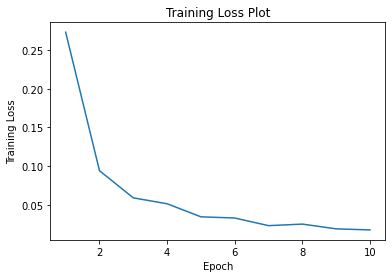

0.7364485981308411
0.9737136465324385
0.7163636363636363
0.7576923076923077
[[5026   78]
 [  63  197]]


In [0]:
from keras.layers import concatenate

input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = ElmoEmbeddingLayer()(input_text)
dense = layers.Dense(200, activation='relu')(embedding)
pred = layers.Dense(2, activation='softmax')(dense)
model1 = Model(inputs=[input_text], outputs=pred)

input_text2 = layers.Input(shape=(1,), dtype=tf.string)
embedding = ElmoEmbeddingLayer()(input_text2)
dense = layers.Dense(200, activation='relu')(embedding)
pred = layers.Dense(2, activation='softmax')(dense)
model2 = Model(inputs=[input_text2], outputs=pred)

model3 = Sequential()
model3.add(Dense(400,input_dim=non_text.shape[1],activation='relu'))
model3.add(Dense(100,activation='relu'))
model3.add(Dense(2,activation='sigmoid'))

model_concat = concatenate([model1.output, model2.output, model3.output], axis=-1)
model_concat = Dense(20, activation='relu')(model_concat)
model_concat = Dense(2, activation='sigmoid')(model_concat)
model= Model(inputs=[model1.input, model2.input,model3.input], outputs=model_concat)

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy',f1])
# model.compile(loss = f1_loss, optimizer='adam',metrics = ['accuracy',f1])
model.summary()
history=model.fit([train_text,train_text_com,non_text_train], Y1_train, epochs=10,batch_size=20,class_weight={0:1, 1:1})
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)
plt.title('Training Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show();

y_pred1=model.predict([test_text,test_text_com,non_text_test], batch_size = 20)
y_pred11=np.argmax(y_pred1,axis=1)
Y1_test11=np.argmax(Y1_test,axis=1)
print(f1_score(Y1_test11, y_pred11))
print(accuracy_score(Y1_test11, y_pred11))
print(precision_score(Y1_test11, y_pred11))
print(recall_score(Y1_test11, y_pred11))
print(confusion_matrix(Y1_test11, y_pred11))